# Using a pretrained model - EfficientNet

We will use transfer learning to achieve both faster training and improved performance. In this notebook we train on the whole EfficientNet without freezing layers.

**Note:** We highly recommend running this notebook on a GPU. 

## 0. Initialization

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
import os

os.chdir("..")
import requests
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
from src.utils import calculate_metrics, seed_everything
from sklearn.metrics import confusion_matrix
from torchvision.models import efficientnet_b3, EfficientNet_B3_Weights
from src.loading import load_data, load_test_data
from src.loading import load_data
from src.train import train

In [4]:
# set the seeds for reproducibility
seed_everything()

# set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



---

<a name='s1'></a>
## 1. Downloading the dataset

Fetching the dataset should take around 4-5 minutes. Unzipping takes 20s.

In [5]:
# if folder 'data/' is does not exist, download the data
if not os.path.exists("data/"):
    # Dropbox URL
    dropbox_url = "https://www.dropbox.com/scl/fi/sa14unf8s47e9ym125zgo/data.zip?rlkey=198bg0cmbmmrcjkfufy9064wm&dl=1"

    # File path where the .zip file will be saved
    file_path = "data.zip"

    response = requests.get(dropbox_url)

    if response.status_code == 200:
        with open(file_path, "wb") as file:
            file.write(response.content)
        message = "Download successful. The file has been saved as 'data.zip'."
    else:
        message = "Failed to download the file. Error code: " + str(
            response.status_code
        )

    print(message)

    # Path to the downloaded .zip file
    zip_file_path = "data.zip"

    # Directory to extract the contents of the zip file, in this current folder
    extraction_path = ""

    # Unzipping the file
    with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
        zip_ref.extractall(extraction_path)

    extraction_message = (
        f"The contents of the zip file have been extracted to: {extraction_path}"
    )

    print(extraction_message)

## 2. Data

Load the data with improved preprocessing. Set the batch size according to your machine, here we tried to set it as high as possible, as long as the GPU/CPU has enough memory.

In [6]:
# Load the .jpeg files in the data folder
PATH_IMAGES = "data/images_keep_ar"
PATH_LABELS = "data/labels/trainLabels.csv"

batch_size = 2  # default 8
img_size = (400, 400)  # default size 120/120
num_epochs = 20

Load train and validation, 90-10 ratio. 

In [7]:
train_loader, validation_loader = load_data(
    PATH_LABELS, PATH_IMAGES, img_size, batch_size
)

Number of train samples:31964
Number of validation samples:3162


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([2, 3, 400, 400])
torch.Size([2])


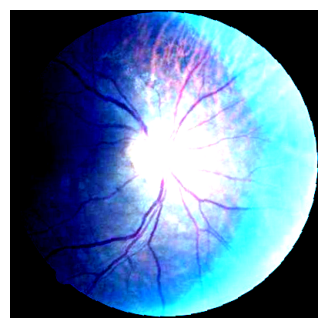

In [8]:
# Visualize a batch of images
for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    plt.figure(figsize=(4, 4))
    plt.axis("off")
    plt.imshow(np.transpose(images[0], (1, 2, 0)))
    plt.show()
    break

## 3. Model

Here we will use a pretrained EfficientNet_B3 pretrained on the ImageNet dataset. This model was the best in our initial analysis so we decided to pursue and try to fine tune it in order to achieve maximum performance.

In [9]:
# Initialize model with the best available weights
weights = EfficientNet_B3_Weights.DEFAULT
model = efficientnet_b3(weights=weights)

For our initial results, all the layer should be frozen. For our secondary results we unfreeze the last three layers. However, for fine-tuning we trained on the whole network. Since our notebooks will be the latest version, all of the layers will be unfrozen when running this notebook.

In [10]:
# # Freeze
# for param in model.parameters():
#     param.requires_grad = False

# replace the last layer
model.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1536, out_features=5, bias=True),
)

# Unfreeze last x layers
# parameters_to_train = []
# # unfreeze the last layer
# for param in model.classifier.parameters():
#     param.requires_grad = True
#     parameters_to_train.append(param)

# for param in model.features[6].parameters():
#     param.requires_grad = True
#     parameters_to_train.append(param)

# for param in model.features[7].parameters():
#     param.requires_grad = True
#     parameters_to_train.append(param)

# for param in model.features[8].parameters():
#     param.requires_grad = True
#     parameters_to_train.append(param)

In [11]:
# Load model checkpoint
MODEL = "results/models/eff_net_400x400.pt"
try:
    model_state_dict = torch.load(MODEL, map_location=lambda storage, loc: storage)
    model.load_state_dict(model_state_dict)
except RuntimeError as e:
    print("Error loading the model:", e)

Initially we went with loss 0.001. For further fine-tuning we lowered the loss, as this proved to be more stable when training.

In [12]:
optimizer = optim.Adam(model.parameters(), lr=3e-5)
criterion = nn.CrossEntropyLoss()
model.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

### 3.1 Model training and evaluation

In [ ]:
train(
    model,
    train_loader,
    validation_loader,
    criterion,
    optimizer,
    device,
    model_name="results/models/eff_net_400x400_test.pt",
    num_epochs=num_epochs,
)

### Submission

The following code is for generating a submission file

In [14]:
# Model path
MODEL = "results/models/eff_net_400x400.pt"

# Initialize model with the best available weights
weights = EfficientNet_B3_Weights.DEFAULT
model = efficientnet_b3(weights=weights)

# Replace the last layer
model.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1536, out_features=5, bias=True),
)

model.to(device)
try:
    model_state_dict = torch.load(MODEL, map_location=lambda storage, loc: storage)
    model.load_state_dict(model_state_dict)
except RuntimeError as e:
    print("Error loading the model:", e)

In [15]:
img_size = (400, 400)
batch_size = 10
test = load_test_data("data/test/", img_size, batch_size)

In [ ]:
# Test loop
model.eval()
test_preds = []
test_names = []
with torch.no_grad():
    for images, names in tqdm(test):
        images = images.to(device)
        outputs = model(images)
        predicted = outputs.argmax(dim=1)
        test_preds.extend(predicted.cpu().numpy())
        test_names.extend(names)

In [ ]:
# Make submission csv, first column "image" second columns "level"
submission = pd.DataFrame({"image": test_names, "level": test_preds})
submission.to_csv("submission.csv", index=False)